# Shallow water equations

This is an example how `sparsegrad` can be used to generate Jacobian of finite element system of three coupled equations. It includes comparison of performance with state-of-the-art automatic differentiation library ADOL-C. 

The model solved is:

$\frac{\partial (\rho \eta) }{\partial t} + \frac{\partial (\rho \eta u)}{\partial x} + \frac{\partial (\rho \eta v)}{\partial y} = 0$

$\frac{\partial (\rho \eta u)}{\partial t} + \frac{\partial}{\partial x}\left( \rho \eta u^2 + \frac{1}{2}\rho g \eta^2 \right) + \frac{\partial (\rho \eta u v)}{\partial y} = 0$

$\frac{\partial (\rho \eta v)}{\partial t} + \frac{\partial (\rho \eta uv)}{\partial x} + \frac{\partial}{\partial y}\left(\rho \eta v^2 + \frac{1}{2}\rho g \eta ^2\right) = 0$

with $\rho = 1$.

For simplicity, upwinding is not included. 

In [1]:
%matplotlib inline
import scipy.sparse.linalg 
import pylab as plt
from sparsegrad.base import *
from sparsegrad.forward import *
import numpy as np

In [2]:
class mesh:
    """Rectangular mesh of size (n,n) with grid_spacing, providing cell centered
    d_dx and d_dy operators"""
    def __init__(self,n,grid_spacing):
        self.n=n
        self.grid_spacing=grid_spacing
        self.ndof=n*n
        self.idx=np.zeros((n,n),dtype=int)
        self.idx.ravel()[:]=np.arange(self.ndof)
        x,y = np.mgrid[:n,:n]
        self.x = x.flatten()
        self.y = y.flatten()
        
        def deriv_op(axis):
            idx_p=np.roll(self.idx,-1,axis).flatten()
            idx_m=np.roll(self.idx,1,axis).flatten()
            def d(x):
                return (x[idx_p]-x[idx_m])/(2*grid_spacing)
            return d
        self.d_dx = deriv_op(0)
        self.d_dy = deriv_op(1)
        
    def twodim(self,x):
        x2=np.zeros((self.n,self.n))
        x2.ravel()[:]=x
        return x2
        
    def zeros(self):
        return np.zeros(self.ndof)

def timestep(residuals,xold,dt,tol,ltol=1e-5,verbose=False):
    "Timestep solver using Newton's method with bicgstab"
    x=xold.copy()
    for i in range(1,10):
        adx=forward.seed(x)
        adxt = (adx-xold)/dt
        adf=residuals(adx,adxt)
        f,df=adf.value,adf.dvalue
        fnorm=np.linalg.norm(f)
        if verbose:
            print('\tNonlinear iteration {i}, |F|={f}'.format(i=i,f=fnorm))
        if fnorm<tol:
            if verbose:
                print('Converged')
            return x
        def callback(*args):
            pass
        delta,status=scipy.sparse.linalg.bicgstab(scipy.sparse.linalg.aslinearoperator(df),-f,callback=callback,
                                                 tol=np.linalg.norm(f)*ltol)
        if status:
            raise RuntimeError('linear solver did not converge to tolerance{ltol}'.format(ltol=ltol))
        x+=delta
    raise RuntimeError('did not converge to tolerance {tol}'.format(tol))

## Solution of example problem

In [3]:
class shallow_water:
    def __init__(self,n,box_size=1.):
        self.box_size = box_size
        self.n = n
        self.mesh = mesh(n, box_size/n)
        self.g = 1
        
    def fields_to_x(self,eta,u,v):
        return stack(eta,u,v)
    
    def x_to_fields(self,x):
        m=self.mesh
        return x[:m.ndof],x[m.ndof:2*m.ndof],x[2*m.ndof:]
    
    def residuals(self,x,xt):
        m,g=self.mesh,self.g
        d_dx,d_dy=m.d_dx,m.d_dy
        eta,u,v=self.x_to_fields(x)
        deta_dt = -d_dx(eta*u) - d_dy(eta*v)
        du_dt = (deta_dt*u - d_dx(eta*u**2 + 1./2*g*eta**2) - d_dy(eta*u*v)) / eta
        dv_dt = (deta_dt*v - d_dx(eta*u*v) - d_dy(eta*v**2 + 1./2*g*eta**2)) / eta
        return xt-self.fields_to_x(deta_dt,du_dt,dv_dt)
    
    def initial_conditions(self,r=10):
        m,n=self.mesh,self.n
        eta = np.where((m.x-n/2)**2+(m.y-n/2)**2<r**2,1.1,1)
        return self.fields_to_x(eta, m.zeros(), m.zeros())   
    
    def imshow(self,plt,x):
        plt.imshow(self.mesh.twodim(self.x_to_fields(x)[0]),interpolation='bicubic')

In [4]:
test_problem=shallow_water(200)

In [5]:
dt=0.005
time=0
x0=test_problem.initial_conditions()
x=x0
for i in range(60):
    print('Timestep {i} at time {time} with dt {dt}'.format(i=i,time=time,dt=dt))
    x=timestep(test_problem.residuals,x,dt,1e-2)
    time+=dt

Timestep 0 at time 0 with dt 0.005
Timestep 1 at time 0.005 with dt 0.005
Timestep 2 at time 0.01 with dt 0.005
Timestep 3 at time 0.015 with dt 0.005
Timestep 4 at time 0.02 with dt 0.005
Timestep 5 at time 0.025 with dt 0.005
Timestep 6 at time 0.030000000000000002 with dt 0.005
Timestep 7 at time 0.035 with dt 0.005
Timestep 8 at time 0.04 with dt 0.005
Timestep 9 at time 0.045 with dt 0.005
Timestep 10 at time 0.049999999999999996 with dt 0.005
Timestep 11 at time 0.05499999999999999 with dt 0.005
Timestep 12 at time 0.05999999999999999 with dt 0.005
Timestep 13 at time 0.06499999999999999 with dt 0.005
Timestep 14 at time 0.06999999999999999 with dt 0.005
Timestep 15 at time 0.075 with dt 0.005
Timestep 16 at time 0.08 with dt 0.005
Timestep 17 at time 0.085 with dt 0.005
Timestep 18 at time 0.09000000000000001 with dt 0.005
Timestep 19 at time 0.09500000000000001 with dt 0.005
Timestep 20 at time 0.10000000000000002 with dt 0.005
Timestep 21 at time 0.10500000000000002 with dt 0.

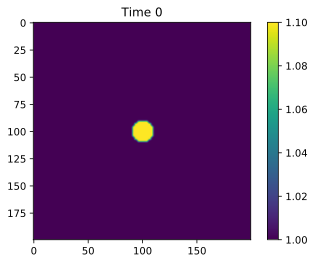

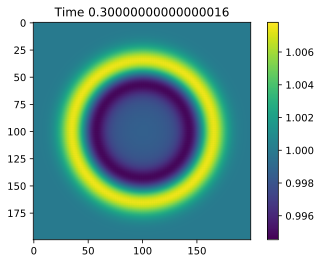

In [6]:
plt.title('Time {time}'.format(time=0))
test_problem.imshow(plt,x0)
plt.colorbar()
plt.show()
plt.title('Time {time}'.format(time=time))
test_problem.imshow(plt,x)
plt.colorbar()
plt.show()

## Timing of automatic differentiation

In [7]:
%timeit test_problem.residuals(x,0.)

2.33 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
adx=forward.seed(x)

In [9]:
%timeit test_problem.residuals(adx,0.)

69.4 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
adf=test_problem.residuals(adx,0.)

In [11]:
adf.dvalue

<120000x120000 sparse matrix of type '<class 'numpy.float64'>'
	with 1280000 stored elements in Compressed Sparse Row format>

## Comparison with ADOL-C

In [12]:
import adolc

In [13]:
def adolc_full(x):
    adolc.trace_on(0)
    adolc_x = np.asarray(list(map(adolc.adouble,x)))
    [adolc.independent(u) for u in adolc_x]
    adolc_f=test_problem.residuals(adolc_x,0.)
    [adolc.dependent(u) for u in adolc_f]
    adolc.trace_off()
    options=np.zeros(4,dtype=int)
    f=adolc.function(0,x)
    nnz,i,j,v=adolc.colpack.sparse_jac_no_repeat(0,x,options)
    def tocsr(nnz,i,j,v):
        return scipy.sparse.csr_matrix((v,(i,j)),shape=x.shape*2)
    def repeated(x):
        f=adolc.function(0,x)
        df=tocsr(*adolc.colpack.sparse_jac_repeat(0,x,nnz,i,j,v))
        return f,df
    return f,tocsr(nnz,i,j,v),repeated

### Numeric values

In [14]:
adolc_f,adolc_j,_=adolc_full(x)

In [15]:
norm_f = np.linalg.norm(adf.value)
norm_diff_f = np.linalg.norm(adf.value-adolc_f)
norm_jacobian = scipy.sparse.linalg.norm(adf.dvalue)
norm_diff_jacobian = scipy.sparse.linalg.norm(adf.dvalue-adolc_j)

In [16]:
print("|delta f|/|f| = {}".format(norm_diff_f/norm_f))

|delta f|/|f| = 4.351870545226969e-17


In [17]:
print("|delta f'|/|f'| = {}".format(norm_diff_jacobian/norm_jacobian))

|delta f'|/|f'| = 2.069537920839901e-20


### Timing of ADOL-C

In [18]:
%timeit adolc_full(x)

2.13 s ± 51.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
_,__,adolc_repeated=adolc_full(x)

In [20]:
%timeit adolc_repeated(x)

142 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test run on Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz.